In [ ]:
# import needed libraries
import numpy as np
import argparse
import time
from random import shuffle
import random
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/myDrive/')

Mounted at /content/myDrive/


In [ ]:
# go to folder with /data and /utils
cd myDrive/MyDrive/ZSL

/content/myDrive/MyDrive/ZSL


# Zero shot learning - final project
## DL for Spiking Neural Networks and Advanced Data Mining

In [ ]:
from scipy import io
att_splits=io.loadmat('./data/AWA2/binaryAtt_splits.mat')
# retrieve all the class names
classes_names = [a[0] for a in np.squeeze(att_splits['allclasses_names'])]
# create helper dictionary from class id to class name
id_to_name = {i:name for (i,name) in enumerate(classes_names)}

### Reading data

In [ ]:
from utils import data_loader
import importlib
# load /utils/data_loader
importlib.reload(data_loader)
# load the data
trainDataX, trainDataLabels, trainDataAttrs, testDataX, testDataLabels, testDataAttrs = data_loader.DataLoader("./data/CUB", binary=False).load()
trainDataX = (trainDataX - np.mean(trainDataX)) / np.std(trainDataX) # normalize image embeddings
testDataX = (testDataX - np.mean(testDataX)) / np.std(testDataX) # normalize image embeddings

# get the number of testing examples
test_size = len(testDataLabels)

In [ ]:
# check total number of classes (test & train)
num_classes = len(np.unique(np.concatenate((trainDataLabels, testDataLabels))))
num_classes

50

### Define useful for evaluation dictionaries

In [ ]:
# create class_id:attribute dictionary
class_attr_dict = {}
for A, B in zip(trainDataLabels, trainDataAttrs):
    # training classes
    class_attr_dict[A] = B
for A, B in zip(testDataLabels, testDataAttrs):
    # testing classes
    class_attr_dict[A] = B

# sort it from smallest to highest id
keys = sorted(class_attr_dict)
class_attr_dict = {i: class_attr_dict[i] for i in keys}
class_attr_dict.keys()

# create dictionary from attributes to a class id
atrr_to_class = {v.tobytes(): k for k, v in class_attr_dict.items()}
all_class_atrs = class_attr_dict.values()


In [ ]:
# create class_id:attribute dictionary for test classes
test_attributes = {}
for A, B in zip(testDataLabels, testDataAttrs):
    test_attributes[A] = B
test_attributes = test_attributes.values()

In [ ]:
# load saved from experiments model
from tensorflow.keras.models import load_model
model = load_model('attributes_regression')

In [ ]:
# all classes names in test dataset
classes = [id_to_name[label] for label in np.unique(testDataLabels)]
# helper: class name (str) to id in confusion matrix dictionary
class_to_conf_matrix = {cl:i for i,cl in enumerate(classes)}

In [ ]:
def difference(class_attribute, prediction):
    ''' calulate difference between predicted and actual attribute values '''
    # assert(len(class_attribute) == len(prediction))
    dif = 0
    # for the each singular attribute in actual attribute representation
    for i, att in enumerate(class_attribute):
        # add the difference between the prediction attribute and class attribute
        dif += abs(prediction[i] - att)
    # return sum of differences
    return dif

def evaluate(pred, printing=False):
  ''' get accuracy of the given model given its prediction of test dataset '''
  correct = 0
  confusion_matrix = [[0]*10 for i in range(10)]

    # iterate through each test example
  for id in range(test_size-1):
    # get distance score
    differences = [difference(att, pred[id]) for att in test_attributes]
    #assert(len(differences)==10)

    # take the id of the min distance
    id_predicted = np.argmin(differences)
    # retrive the class id of the min distance
    class_prediction = atrr_to_class[list(test_attributes)[id_predicted].tobytes()]

    # optional printing
    if printing:
      print(f"predicted class: {class_prediction} real class : {testDataLabels[id]}")
      print(f"predicted class: {id_to_name[class_prediction]} real class : {id_to_name[testDataLabels[id]]}")
      print(f"CORRECT:::??? ->>> {class_prediction == testDataLabels[id]}")

    # if correct, add to correct variable
    if class_prediction == testDataLabels[id]:
      correct += 1

    # update confusion matrix
    confusion_matrix[class_to_conf_matrix[id_to_name[testDataLabels[id]]]][class_to_conf_matrix[id_to_name[class_prediction]]] += 1

  # return accuracy
  return correct/test_size, confusion_matrix

In [ ]:
# get accuracy and confusion matrix from prediction on test set
acc, conf_matrix = evaluate(model.predict(testDataX))

248/248 [==============================] - 4s 2ms/step


In [ ]:
acc # print accuracy

0.4733982054846455

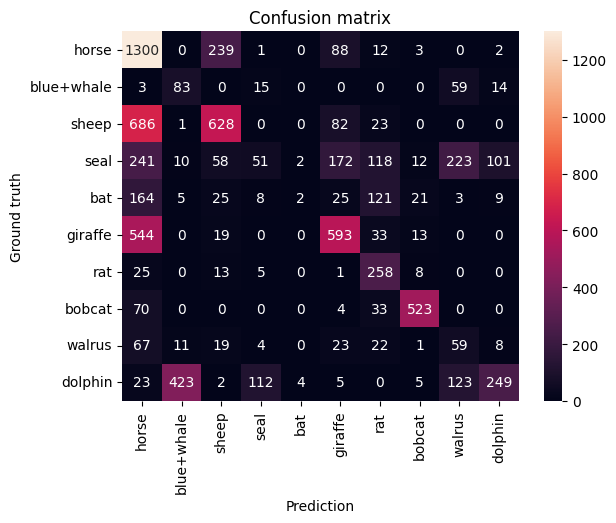

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualise confusion matrix
ax = plt.axes()
sns.heatmap(conf_matrix, ax = ax, xticklabels = classes, yticklabels = classes, annot=True, fmt='d')
ax.set_title('Confusion matrix')
ax.set_ylabel('Ground truth')
ax.set_xlabel('Prediction')
plt.show()